In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [8]:
import addict
import copy
import datetime
import json
import meshio
import os
import pickle
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from ismember import ismember
import matplotlib
import colorcet as cc
from scipy.interpolate import SmoothBivariateSpline

import skies


In [3]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


output_path='./runs/2022_10_05_15_17_39'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52
Maximum allowed moment magnitude = 9.00
Minimum allowed moment magnitude = 7.00
Maximum moment magnitude of entire mesh (10.61) exceeds MAXIMUM_EVENT_MOMENT_MAGNITUDE


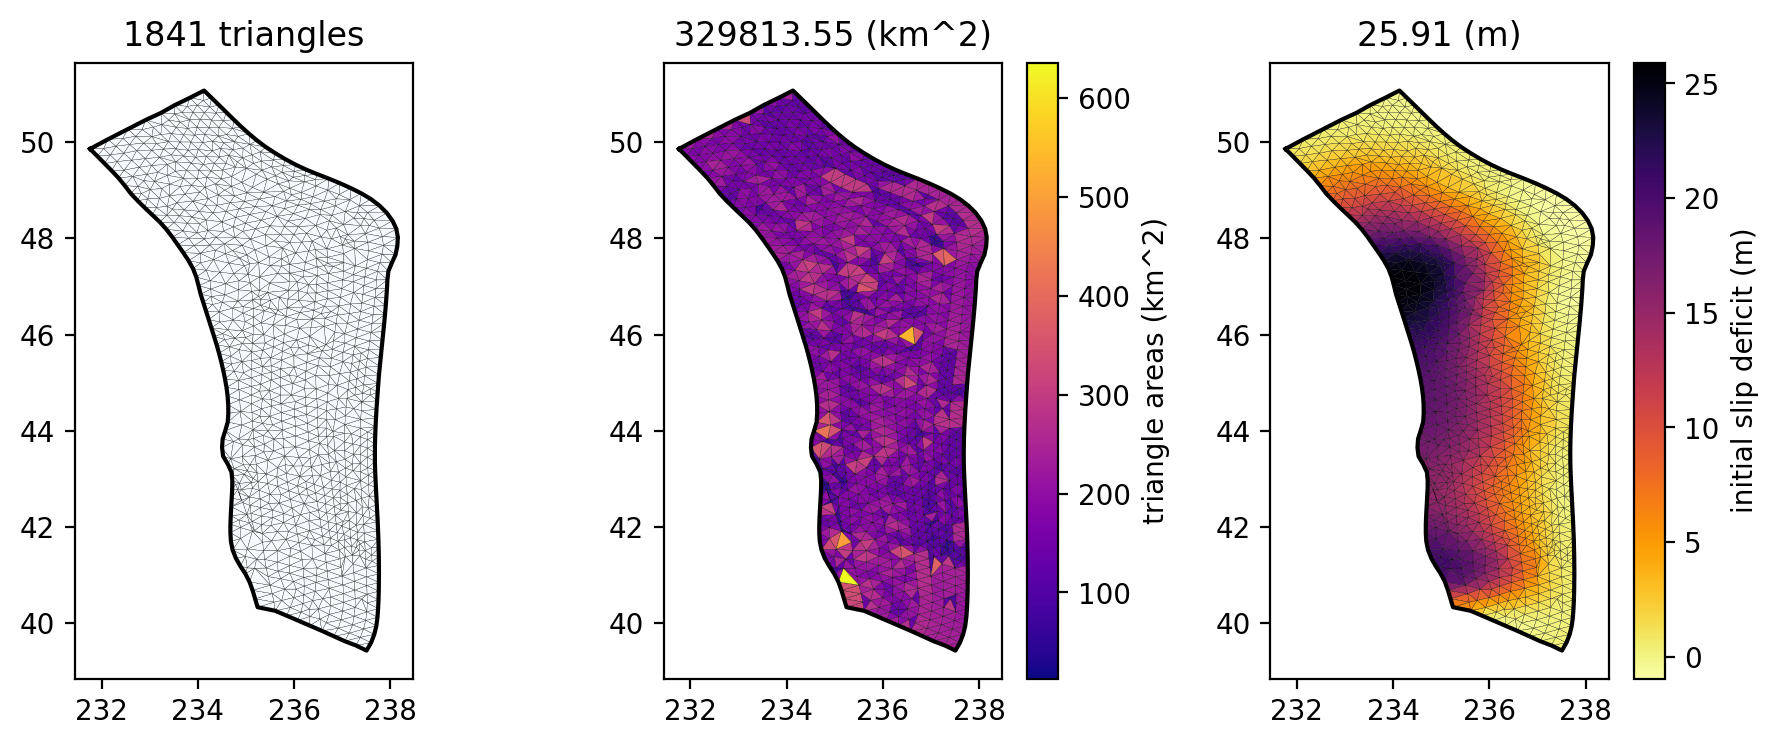

In [4]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([10.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = skies.get_synthetic_accumulated_slip(meshes[0], sources)
initial_dip_slip_deficit = initial_slip_deficit[1::2]

# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
initial_dip_slip_deficit = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")

total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
skies.plot_initial_data(meshes, initial_dip_slip_deficit)


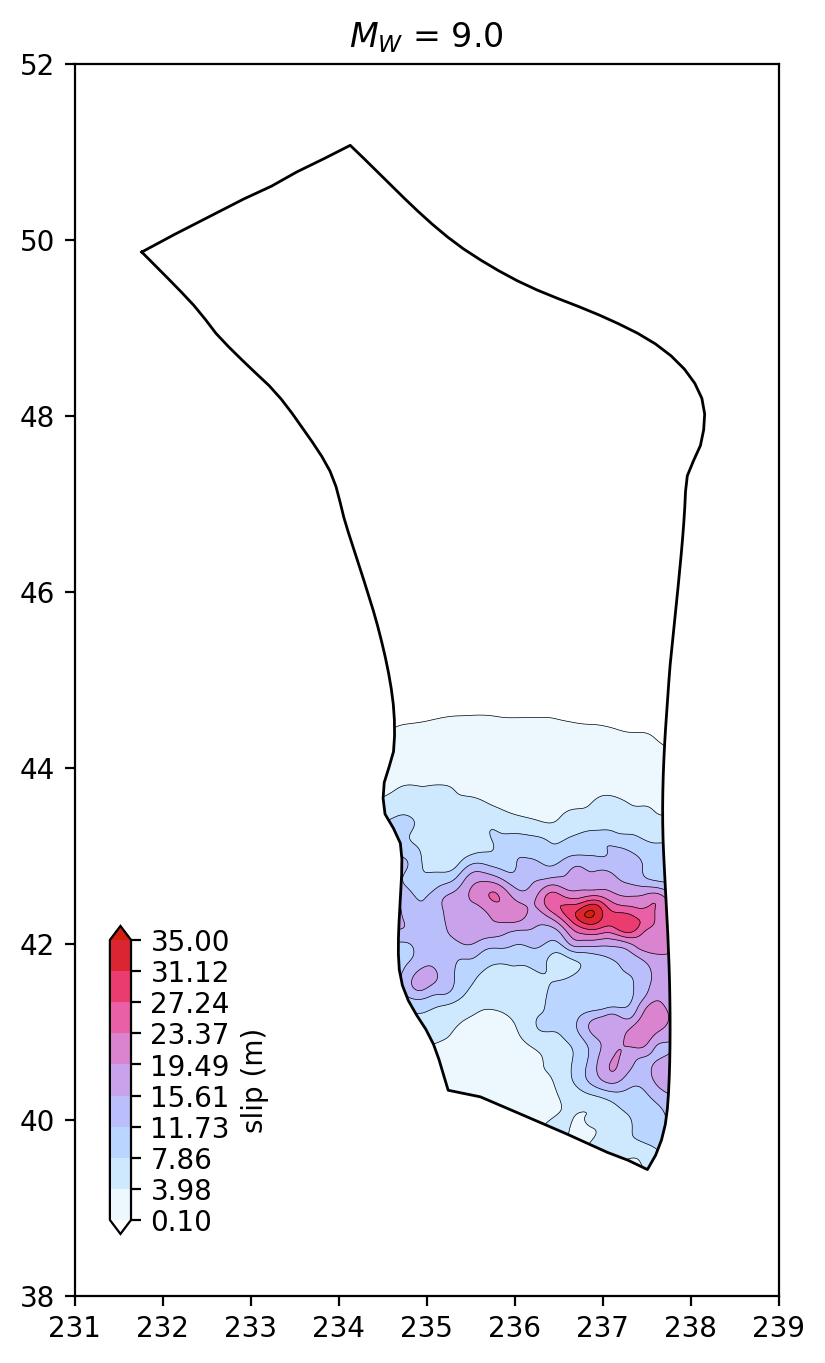

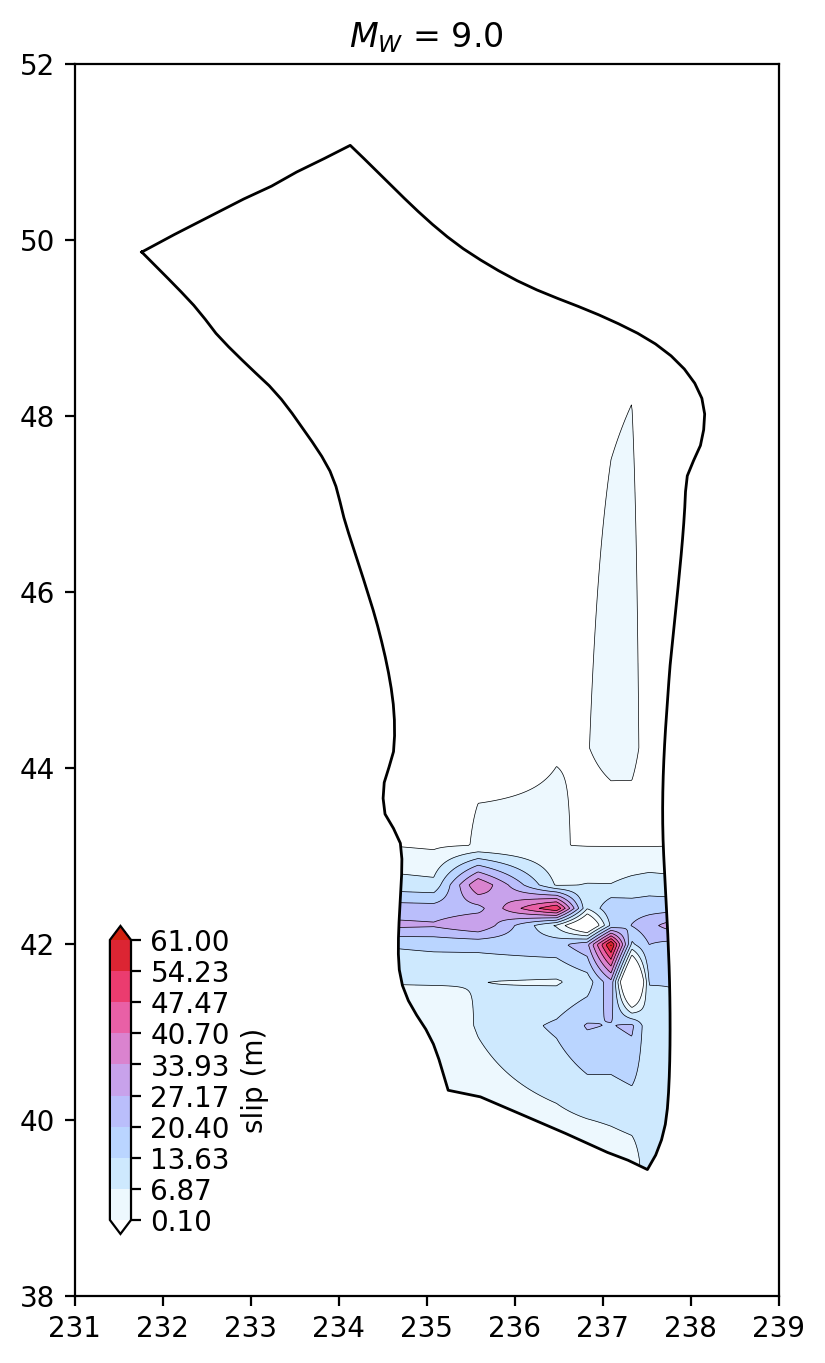

In [114]:
# Event basics
event = addict.Dict()
event.moment_magnitude = 9.0
event.hypocenter_longitude = 235.87495333  #  (degrees)
event.hypocenter_latitude = 40.94505867  #  (degrees)
event.hypocenter_depth = -15.36972933  # (km)
event.shear_modulus = 3e10
event.area_scaling = 1.25
# event = skies.get_event_area_slip_triangle_index(meshes[0], event)
event = skies.get_event_area_slip_hypocenter(meshes[0], event)

# Run parameters
params = addict.Dict()
params.n_grid_longitude = 1000
params.n_grid_latitude = 1000
params.min_longitude = 231.0
params.max_longitude = 239.0
params.min_latitude = 38.0
params.max_latitude = 52.0
params.n_contour_levels = 10
params.min_contour_value = 0.1  # (m)


def quick_plot_slip(mesh, event, params):
    plt.figure(figsize=(8, 8))
    fill_value = event.slip_all_elements
    xgrid, ygrid = skies.rbf_interpolate_single_mesh(mesh, params, fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = skies.inpolygon(
        xflat[:, 0], xflat[:, 1], mesh.x_perimeter, mesh.y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    cmap = cc.cm.CET_L19
    levels = np.linspace(0.1, np.floor(np.nanmax(ygrid)), params.n_contour_levels)
    plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
    cb = plt.colorbar(
        cax=plt.gca().inset_axes((0.05, 0.05, 0.03, 0.25)), label="slip (m)"
    )
    # cb.ax.tick_params(labelsize=18)
    cb.set_label(label="slip (m)", size=10)
    cb.ax.tick_params(labelsize=10)
    plt.contour(
        *xgrid,
        ygrid,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(mesh.x_perimeter, mesh.y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"$M_W$ = {event.moment_magnitude:0.3}")
    plt.show()


quick_plot_slip(meshes[0], event, params)

plt.figure(figsize=(8, 8))
mesh = meshes[0]
x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)

fill_value = event.slip_all_elements
centroids_lon = mesh.centroids[:, 0]
centroids_lat = mesh.centroids[:, 1]
centroids_val = fill_value

interp_spline = SmoothBivariateSpline(
    mesh.centroids[:, 0], mesh.centroids[:, 1], fill_value, w=None, kx=1, ky=1
)
# ygrid = interp_spline(x_mat.flatten(), y_mat.flatten(), grid=False)  # TODO: Flip order?
ygrid = interp_spline(x_mat.flatten(), y_mat.flatten(), grid=False)  # TODO: Flip order?

ygrid = np.reshape(ygrid, x_mat.shape)
inpolygon_vals = skies.inpolygon(
    x_mat.flatten(), y_mat.flatten(), mesh.x_perimeter, mesh.y_perimeter
)

inpolygon_vals = np.reshape(
    inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
)
ygrid[~inpolygon_vals] = np.nan

# Plot
cmap = cc.cm.CET_L19
levels = np.linspace(0.1, np.floor(np.nanmax(ygrid)), params.n_contour_levels)
plt.contourf(x_mat, y_mat, ygrid, cmap=cmap, levels=levels, extend="both")

cb = plt.colorbar(cax=plt.gca().inset_axes((0.05, 0.05, 0.03, 0.25)), label="slip (m)")
# cb.ax.tick_params(labelsize=18)
cb.set_label(label="slip (m)", size=10)
cb.ax.tick_params(labelsize=10)
plt.contour(
    # *xgrid,
    x_mat,
    y_mat,
    ygrid,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
plt.plot(mesh.x_perimeter, mesh.y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title(f"$M_W$ = {event.moment_magnitude:0.3}")
plt.show()


In [98]:
y_mat.shape

(100, 100)

In [ ]:
event.triangle_index


In [ ]:
np.random.seed(1)


def get_omori_decay_probability(time_vector, time_of_earthquake, amplitude, decay_time):
    omori_decay_probability = amplitude / (
        1 + (1 / decay_time) * (time_vector - time_of_earthquake)
    )

    omori_decay_probability[time_vector < time_of_earthquake] = 0.0
    return omori_decay_probability


MM2M = 1e-3  # millimeters to meters
SECONDS_IN_A_YEAR = 60 * 60 * 24 * 365
DAYS_IN_A_YEAR = 365
n_years = 100
time_vector = np.linspace(0, n_years, n_years * 1)
minimum_probability = 1e-5
time_probability = np.zeros_like(time_vector)
time_probability = minimum_probability * np.ones_like(time_vector)

# loading_rate = 30.0  # (mm/yr)
earthquake_index_list = []
earthquake_magnitude_list = []
earthquake_probability_list = []
event_trigger_list = []

b_value = -1.0
minimum_event_moment_magnitude = 7.0
maximum_event_moment_magnitude = 9.0

amplitude = 0.01

# Initial conditions
pre_event_slip_deficit = np.copy(initial_dip_slip_deficit)
total_slip_deficit = 1e-1 * np.copy(initial_dip_slip_deficit)
total_slip_deficit_scalar = np.zeros_like(time_vector)
total_slip_deficit_scalar[0] = np.sum(total_slip_deficit)

# Intial geometric moment deficit and storage
total_geometric_moment_deficit = initial_dip_slip_deficit * meshes[0].areas
total_geometric_moment_deficit_scalar = np.zeros_like(time_vector)
total_geometric_moment_deficit_scalar[0] = np.sum(
    initial_dip_slip_deficit * meshes[0].areas
)

time_step = 1e-6
interseismic_loading_rate = initial_dip_slip_deficit
time_probability_step = 0.00005
time_probability_step = 1e-10

candidate_event = addict.Dict()

# Main time loop
for i in range(0, len(time_vector) - 1):

    # Determine whether there is an event at this time step
    event_trigger = np.random.choice(
        2, 1, p=[1 - time_probability[i], time_probability[i]]
    )
    event_trigger_list.append(event_trigger)

    # Magnitude of candidate earthquake
    candidate_event.moment_magnitude = skies.get_gutenberg_richter_magnitude(
        b_value, minimum_event_moment_magnitude, maximum_event_moment_magnitude
    )

    # Do we have enough stored moment for a candidate event of this size
    # Candidate event moment and geometric moment
    AREA_SCALING = 1.25
    candidate_event.moment = 10 ** (
        1.5 * (candidate_event.moment_magnitude + 10.7) - 7.0
    )
    SHEAR_MODULUS = 3e10
    candidate_event.geometric_moment = candidate_event.moment / SHEAR_MODULUS
    if candidate_event.geometric_moment < total_geometric_moment_deficit_scalar[i]:
        geometric_moment_condition = True
    else:
        geometric_moment_condition = False
        print(f"Geometric moment conditions fails at: {i=}")

    # Do we have an earthquake at this time step?
    if bool(event_trigger) and (np.sum(total_slip_deficit) > 0):
        print(f"Earthquake at time step: {i}")
        # Generate a synthetic earthquake
        location_probability = skies.get_location_probability(pre_event_slip_deficit)

        # TODO: Unbundle event creation
        # skies.create_event_target(meshes, magnitude, hypocenter_location)
        event = skies.create_event(meshes, location_probability)
        event.location_probability = location_probability
        event.pre_event_slip_deficit = pre_event_slip_deficit
        event.post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements

        earthquake_magnitude_list.append(event.moment_magnitude)
        earthquake_index_list.append(i)
        earthquake_probability_list.append(
            get_omori_decay_probability(
                time_vector, time_vector[i], amplitude, decay_time=100.0
            )
        )
        event.magnitude_dependent_amplitude = (
            amplitude + amplitude * event.moment_magnitude / 500
        )

        # Update the total slip deficit mesh
        total_slip_deficit = (
            total_slip_deficit
            + time_step * interseismic_loading_rate
            - event.slip_all_elements
        )

        # Update probability for event occurrence at the next time step
        time_probability[i + 1] = (
            time_probability[i] + time_step + event.magnitude_dependent_amplitude
        )

        # Save event dictionary as pickle file
        event_pickle_file_name = f"{output_path}/event_{i:010.0f}.pickle"
        with open(event_pickle_file_name, "wb") as pickle_file:
            pickle.dump(event, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

    else:
        # Update total_slip_deficit for the case when there are no earthquakes
        total_slip_deficit = total_slip_deficit + time_step * interseismic_loading_rate

        # Update time probability for event occurence at the next time step
        time_probability[i + 1] = time_probability[i] + time_step * np.sum(
            interseismic_loading_rate
        )

        # Sum contribution from all past earthquakes
        # TODO: The scaling factor here is magic
        for j in range(len(earthquake_index_list)):
            time_probability[i + 1] += 1.5 * (
                earthquake_probability_list[j][i + 1]
                - earthquake_probability_list[j][i]
            )

    total_geometric_moment_deficit_scalar[i + 1] = np.sum(
        total_slip_deficit * meshes[0].areas
    )

    # Update the total slip deficit scalar
    total_slip_deficit_scalar[i + 1] = np.sum(total_slip_deficit)

    # Pre-event slip deficit for next time step
    pre_event_slip_deficit = np.copy(total_slip_deficit)

    # Catch probabilities less than zero
    if time_probability[i + 1] < minimum_probability:
        time_probability[i + 1] = minimum_probability
        print(f"time_probability < 0.0 at step {i}")

    # Catch probabilities greater than one
    if time_probability[i + 1] >= 1.0:
        time_probability[i + 1] = 1.0
        print(f"time_probability > 1.0 at step {i}")

print(np.where(np.array(event_trigger_list) == 1)[0])


In [ ]:
start_idx = 0
end_idx = 400000
figsize = (15, 3)

plt.figure(figsize=figsize)
# plt.plot(
#     [np.min(time_vector[start_idx:end_idx]), np.max(time_vector[start_idx:end_idx])],
#     [0, 0],
#     "-k",
#     linewidth=0.5,
# )
plt.plot(
    time_vector[start_idx:end_idx],
    total_slip_deficit_scalar[start_idx:end_idx],
    "-r",
    linewidth=0.5,
)
plt.xlabel("time index")
plt.ylabel("$\hat{s}_\mathrm{d}$ (m)")
# plt.xlim([np.min(time_vector), np.max(time_vector)])
# plt.ylim([1e-4, 1])


plt.figure(figsize=figsize)
plt.plot(event_trigger_list[start_idx:end_idx], "r.")
plt.xlabel("time index")
plt.ylabel("event_trigger")
plt.show()


In [ ]:
# Probability in time: Semilogy plot
plt.figure(figsize=(10, 3))
plt.semilogy(time_vector, time_probability, "-k", linewidth=0.5, zorder=35)
fill_x = np.append(time_vector, np.array([np.max(time_vector), 0]))
fill_y = np.append(
    time_probability, np.array([minimum_probability, minimum_probability])
)
plt.fill(
    fill_x,
    fill_y,
    color="lightsteelblue",
    alpha=1.0,
    edgecolor=None,
    zorder=10,
)

cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.02, 0.94, 0.15, 0.03)),
    label="magnitude",
    orientation="horizontal",
    ticks=[6, 7, 8, 9],
)
cb.ax.tick_params(labelsize=10)

plt.plot(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    ".k",
    markersize=3,
    zorder=50,
)

plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([1e-4, 1])
# plt.savefig("example_probability_time_series_semilogy.pdf")
# plt.savefig("example_probability_time_series_semilogy.png", dpi=500)
plt.show()

# Earthquake magnitude plot
plt.figure(figsize=(10, 3))
for i in range(len(earthquake_index_list)):
    plt.plot(
        [time_vector[earthquake_index_list[i]], time_vector[earthquake_index_list[i]]],
        [6.0, earthquake_magnitude_list[i]],
        "-",
        # markersize=10**(earthquake_magnitude_list[i] - 6),
        linewidth=0.25,
        zorder=10,
        color="k",
    )


cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    earthquake_magnitude_list,
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)

# for i in range(len(earthquake_index_list)):
#     plt.plot(
#         time_vector[earthquake_index_list[i]],
#         earthquake_magnitude_list[i],
#         ".",
#         markersize=10 ** (earthquake_magnitude_list[i] - 6),
#         # markersize=10,
#         alpha=1.0,
#         linewidth=0.0,
#         zorder=20,
#         color="orange",
#         markeredgecolor="k",
#         markeredgewidth=0.25,
#     )
plt.xlabel("time index")
plt.ylabel("magnitude")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([6, 10])
# plt.grid(True, linewidth=0.5, linestyle="--")

# plt.savefig("example_magnitude_time_series_semilogy.pdf")
# plt.savefig("example_magnitude_time_series_semilogy.png", dpi=500)
plt.show()


In [ ]:
# # Read event dictionary from pickle file
# with open(event_pickle_file_name, "rb") as pickle_file:
#     event_pp = pickle.load(pickle_file)


In [ ]:
b_value = -1.0
minimum_event_moment_magnitude = 7.0
maximum_event_moment_magnitude = 9.0
n = 10000
temp = np.zeros(n)

for i in range(n):
    temp[i] = skies.get_gutenberg_richter_magnitude(
        b_value, minimum_event_moment_magnitude, maximum_event_moment_magnitude
    )
plt.figure()
plt.hist(temp, log=True)
plt.show()


(5000, 5000)


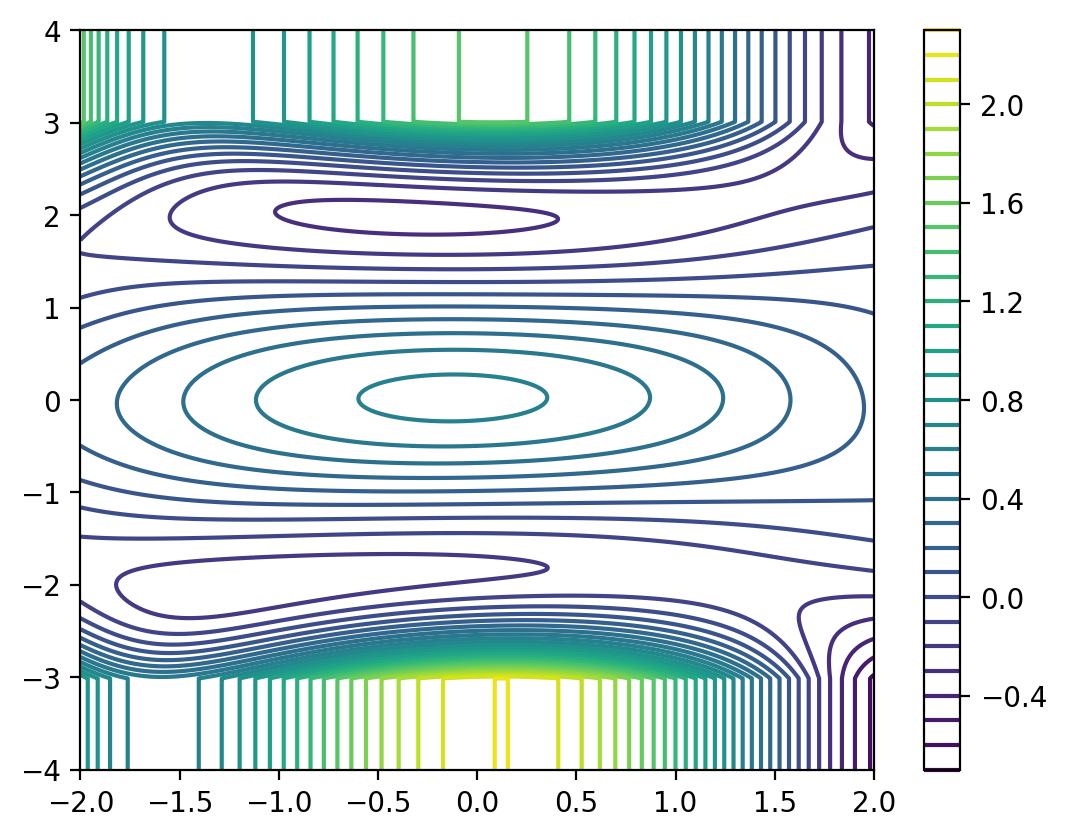

(5000, 5000)


In [106]:
# Alternative to RBF interpolation?

# https://stackoverflow.com/questions/53857403/scipy-interpolation-speed-is-there-anything-faster-than-rectbivariatespline


from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import SmoothBivariateSpline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Regularly-spaced, coarse grid
dx, dy = 0.4, 0.4
xmax, ymax = 1.5, 4
x = np.arange(-xmax, xmax, dx)
y = np.arange(-ymax, ymax, dy)

x = np.random.randn(1500)
y = np.random.randn(1500)
z = np.exp(-((2 * x) ** 2) - (y / 2) ** 2)


X, Y = np.meshgrid(x, y)
Z = np.exp(-((2 * X) ** 2) - (Y / 2) ** 2)

# interp_spline = RectBivariateSpline(y, x, Z)
interp_spline = SmoothBivariateSpline(x, y, z, w=None, kx=4, ky=4)

# Regularly-spaced, fine grid
dx2, dy2 = 0.16, 0.16
n_pts = 5000
x2 = np.linspace(-2.0, 2.0, n_pts)
y2 = np.linspace(-4.0, 4.0, n_pts)
X2, Y2 = np.meshgrid(x2, y2)
Z2 = interp_spline(Y2.flatten(), X2.flatten(), grid=False)
Z2 = np.reshape(Z2, (5000, 5000))
print(Z2.shape)
plt.figure()
# plt.plot(x, y, "r+")
plt.contour(X2, Y2, Z2, levels=30)
plt.colorbar()
plt.show()

print(Z2.shape)
